# MASTML

In [1]:
import pickle
import numpy as np
import pandas as pd
import itertools
from mastml.mastml import Mastml
from mastml.feature_generators import ElementalFeatureGenerator, ElementalFractionGenerator
import matplotlib.pyplot as plt
import random

## Load Data

In [2]:
pfile_X = "Codes/bandgap_pbe_X.pickle"
pfile_Y = "Codes/bandgap_pbe_Y.pickle"

In [3]:
with open(pfile_X, 'rb') as f:
    data = pickle.load(f)

In [4]:
with open(pfile_Y, 'rb') as f:
    data_y = pickle.load(f)

In [21]:
# PARSE DATA

x_clean = data[['composition', 'structure', 'space group']]

composition = x_clean['composition']
structure = x_clean['structure']

compositions = [comp for i, comp in enumerate(composition)]

print("num compositions", len(compositions))

num compositions 74992


### Vectorize

In [102]:
# subset n random values
n = 1000
data_y_list = data_y.T.values.tolist()[0]
l = list(zip(compositions, data_y_list))
subset_compositions, subset_y = zip(*random.sample(l, n))
x_df = pd.DataFrame(subset_compositions)

e_features = ElementalFeatureGenerator(x_df)
e_fraction = ElementalFractionGenerator(x_df)

e_features.fit()
e_fraction.fit()
feat_x, _ = e_features.transform()

# efg_x, efg_y = efg.transform(fraction=False) # ! Cannot use custom function here because of how library is loaded (I did it locally...)
frac_x, frac_y = e_fraction.transform()

x = feat_x
y = subset_y

Dropping 5/440 generated columns due to missing values


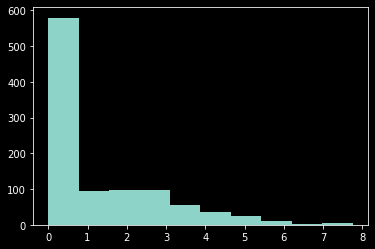

In [103]:
# check that the y is reasonable
plt.hist(y)
plt.show()

### Featurize

In [104]:
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.models import SklearnModel

In [105]:
model = SklearnModel(model='RandomForestRegressor')
selector = EnsembleModelFeatureSelector(model=model, 
                                        n_features_to_select=25)
X_selected = selector.evaluate(X=x, y=y)

In [106]:
# print(X_selected)
x = X_selected

# _ = plt.ist(y)
# plt.show()

## GPR

In [107]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, ConstantKernel
import time

#### GPR for ElementalFeatureGenerator information

In [108]:

gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)
stime = time.time()
print("Start fitting")
gpr.fit(x, y)
print("Time for GPR fitting: %.3f" % (time.time() - stime))
print("Done")

Start fitting
Time for GPR fitting: 53.376
Done


/Users/averychan/opt/anaconda3/envs/MAST_ML_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


In [109]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

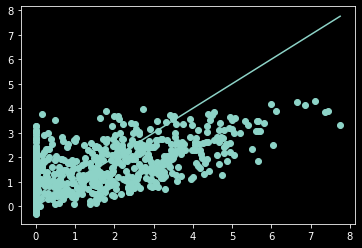

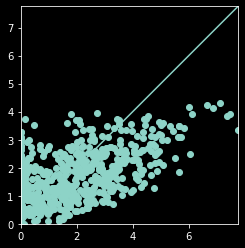

R^2 score: 0.49043944909403103
R^2 score / std: 0.7138351006401751


In [110]:
# EVALUATE PERFORMANCE for all data points

y_, std_ = gpr.predict(x, return_std=True)

# _ = plt.hist(y_)
# plt.show()
# _ = plt.hist(std_)
# plt.show()


def showScores(x, y, y_):
    """Show evaluation metrics given `x`, `y`, and predicted y, `y_`"""
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    max_val = max(max(y), max(y_))
    ax.plot([0, max_val], [0, max_val])
    plt.show()

    max_val = max(max(y), max(y_))
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    ax.set_xlim((0, max_val))
    ax.set_ylim((0, max_val))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()

    r2_score = gpr.score(x, y)
    print(f"R^2 score: {r2_score}")
    err = rmse(y, y_) / np.std(y)
    print(f"R^2 score / std: {err}")


showScores(x, y, y_)


#### GPR for atomic table

In [59]:
# list(x.items())
# print(*x.items(), sep="\n")
# print(x.iloc[0])

## verify rows sum to 1
# total = x.sum(axis=1, numeric_only= True)
# print("total", total)

# material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
material_group_char = ["O"]
thresholds = [0]
for mat in material_group_char:
    continue
    print("Grouping for", mat)
    st1 = 100
    st2 = 10

    for th in thresholds:
        # Make split
        group_X = x[x[mat] > th]
        not_group_X = x[x[mat] <= th]
        # group_y = [None for x in group_X]
        # not_group_y = [None for x in not_group_y]
        group_y = y[x[mat] > th]
        not_group_y = y[x[mat] <= th]

        perc_in_group = group_X.shape[0]/x.shape[0]
        print(f"\ttheshold:\t{th}\n\tpercent in {mat}_group:\t{perc_in_group}")
        # if the split leaves an empty group skip
        if perc_in_group == 0:
            continue

        # group_X.iloc(100)
        group_X = np.array(group_X)
        group_y = np.array(group_y)

        group_X = group_X[0:1000,:]
        group_y = group_y[0:1000,:]
        
        # do GPR stuff
        print(f"Doing GPR for {mat}")
        # gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1) 
        gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
        gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)
        print("gpr:", gpr)
        # break
        stime = time.time()
        print("Start fitting")
        # gpr.fit(group_X, group_y)
        print("Time for GPR fitting: %.3f" % (time.time() - stime))
        print("Done")

        x_, std_ = gpr.predict(group_X, return_std=True)
        print("x_", x_)
        print("std_", std_)

        # Predict using gaussian process regressor
        # stime = time.time()
        # y_gpr = gpr.predict(X_plot, return_std=False)
        # print("Time for GPR prediction: %.3f" % (time.time() - stime))

# gpr.kernel_
# np.std(group_X)